In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

Initialization of hyperparameters

In [2]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [3]:
discriminator_input_dim = 28 * 28
discriminator_output_dim = 1

generator_input_dim = 100
generator_output_dim = 28 * 28

hidden_layer_dim = 128

epoch_dim = 50000
batch_size = 128

In [4]:
mnist = input_data.read_data_sets('../MNIST_data', one_hot=True)

condition_dim = mnist.train.labels.shape[1]

Extracting ../MNIST_data/train-images-idx3-ubyte.gz


Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
x_discriminator = tf.placeholder("float32", shape=[None, discriminator_input_dim])

x_generator = tf.placeholder("float32", shape=[None, generator_input_dim])

x_conditional = tf.placeholder("float32", shape=[None, condition_dim])

In [6]:
D_W1 = tf.Variable(xavier_init([discriminator_input_dim + condition_dim, hidden_layer_dim]))
D_B1 = tf.Variable(tf.zeros(shape=[hidden_layer_dim]))

D_W2 = tf.Variable(xavier_init([hidden_layer_dim, discriminator_output_dim]))
D_B2 = tf.Variable(tf.zeros(shape=[discriminator_output_dim]))

theta_D = [D_B1, D_B2, D_W1, D_W2]

G_W1 = tf.Variable(xavier_init([generator_input_dim + condition_dim, hidden_layer_dim]))
G_B1 = tf.Variable(tf.zeros(shape=[hidden_layer_dim]))

G_W2 = tf.Variable(xavier_init([hidden_layer_dim, generator_output_dim]))
G_B2 = tf.Variable(tf.zeros(shape=[generator_output_dim]))

theta_G = [G_B1, G_B2, G_W1, G_W2]

In [7]:
def discriminator(x, condition):
    input = tf.concat(axis=1, values=[x, condition])
    discriminator_hidden = tf.nn.relu(tf.matmul(input, D_W1) + D_B1)
    discriminator_output = tf.matmul(discriminator_hidden, D_W2) + D_B2
    return discriminator_output


def generator(x, condition):
    input = tf.concat(axis=1, values=[x, condition])
    generator_hidden = tf.nn.relu(tf.matmul(input, G_W1) + G_B1)
    generator_output = tf.matmul(generator_hidden, G_W2) + G_B2
    generator_output_activated = tf.nn.sigmoid(generator_output)
    return generator_output_activated

In [8]:
discriminator_logit_real = discriminator(x_discriminator, x_conditional)
discriminator_logit_fake = discriminator(generator(x_generator, x_conditional), x_conditional)
discriminator_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logit_real, labels=tf.ones_like(discriminator_logit_real)))
discriminator_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logit_fake, labels=tf.zeros_like(discriminator_logit_fake)))
discriminator_loss = discriminator_loss_real + discriminator_loss_fake
discriminator_optimizer = tf.train.AdamOptimizer().minimize(discriminator_loss, var_list=theta_D)

generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logit_fake, labels=tf.ones_like(discriminator_logit_fake)))
generator_optimizer = tf.train.AdamOptimizer().minimize(generator_loss, var_list=theta_G)

In [9]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

In [10]:
def sample(a, b):
    return np.random.uniform(-1., 1., size=[a, b])

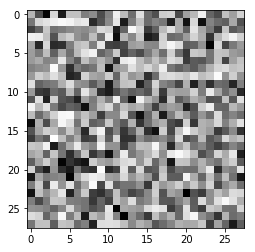

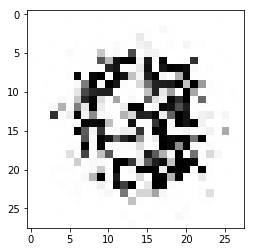

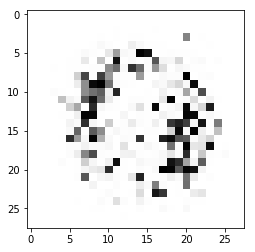

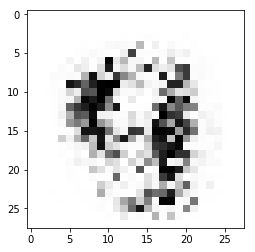

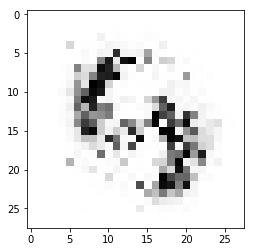

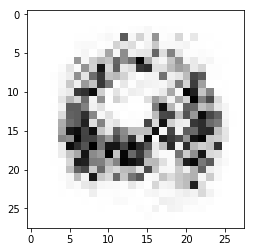

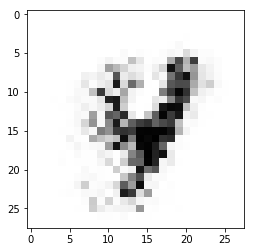

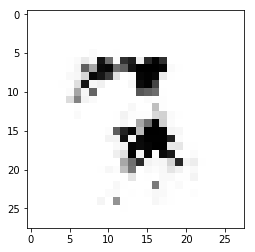

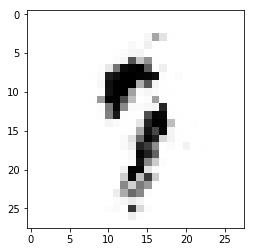

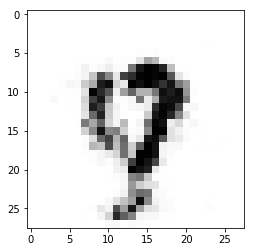

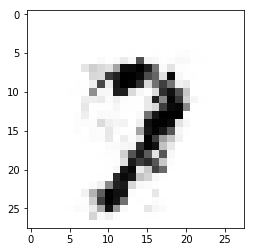

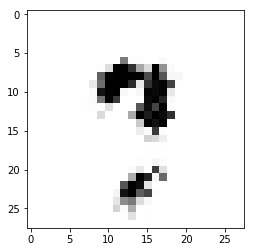

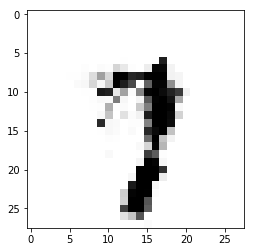

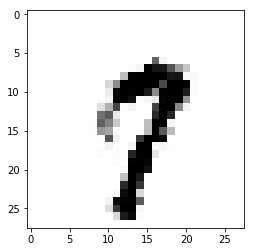

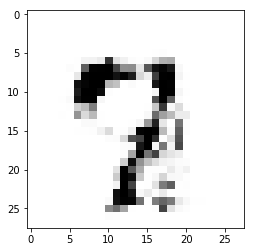

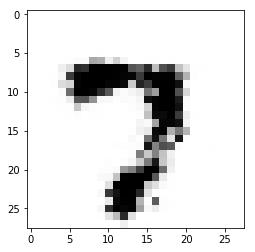

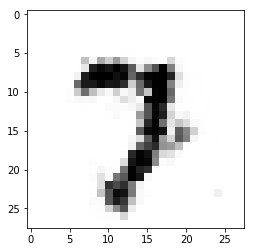

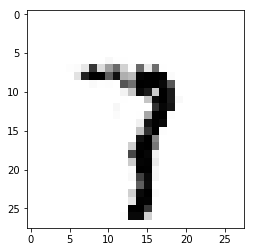

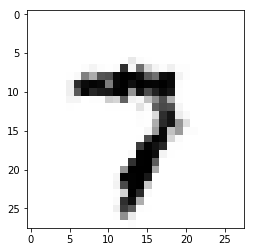

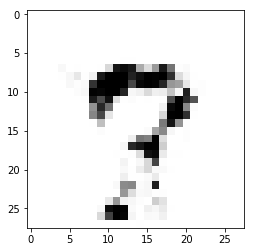

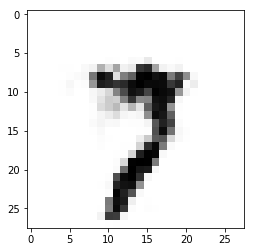

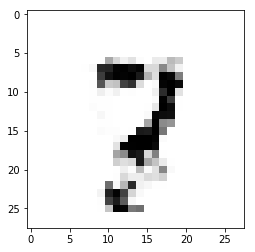

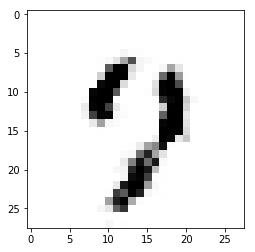

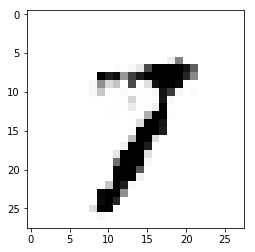

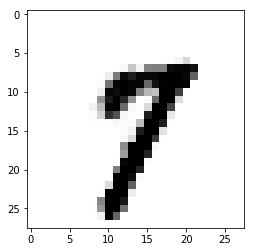

In [11]:
for epoch in range(epoch_dim):
    batch_pic, batch_label = mnist.train.next_batch(batch_size)
    if epoch % 1000 == 0:
        con = np.zeros(shape=[1, condition_dim])
        con[:, 7] = 1
        plt.imshow(generator(x_generator, x_conditional).eval(feed_dict={x_generator:sample(1, generator_input_dim), x_conditional:con}).reshape(28, 28), cmap="Greys")
        plt.show()
    sess.run([discriminator_optimizer, discriminator_loss], feed_dict={x_discriminator: batch_pic, x_generator:sample(batch_size, generator_input_dim), x_conditional:batch_label})
    sess.run([generator_optimizer, generator_loss], feed_dict={x_generator:sample(batch_size, generator_input_dim), x_conditional:batch_label})